<a href="https://colab.research.google.com/github/Deep-Learning-Grupo-8/Proyecto-Final-P-blico/blob/main/Entregable2_TA_G8_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de búsqueda semántica imagen-texto con CLIP

- Fine-tuning CLIP (Imagen + Texto) para Búsqueda Semántica
- PyTorch + Hugging Face (Transformers, Datasets, Accelerate)

## Importaciones y configuración inicial

In [ ]:
import os
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Any
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import load_dataset, DatasetDict
from transformers import (
    CLIPModel,
    CLIPProcessor,
    get_cosine_schedule_with_warmup,
)

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)
torch.backends.cudnn.benchmark = True  # acelerar convoluciones en GPU


Usando dispositivo: cuda


## Configuración para el entrenamiento, modelo, ubicacion dataset

In [ ]:

class CFG:
    hf_dataset_id = "Naveengo/flickr8k"  # dataset en Hugging Face
    model_id      = "openai/clip-vit-base-patch32"  # modelo base CLIP
    output_dir    = "./clip_flickr8k_runs"

    # splits (si el dataset no trae splits, los creamos):
    train_size = 6000
    val_size   = 1000
    test_size  = 1000
    seed       = 31

    # entrenamiento
    batch_size        = 64
    num_epochs        = 20            # empezar con 5; subir a 20 o mas
    lr_vision_text    = 5e-6         # LR muy pequeña para no destruir CLIP
    weight_decay      = 1e-4
    warmup_ratio      = 0.05
    grad_clip_norm    = 1.0
    use_amp           = True         # mixed precision
    freeze_vision     = False        # puedes poner True para “warmup”
    freeze_text       = False        # idem

    # evaluación
    eval_every_steps  = 200          # eval periódica en valid
    topk              = (1, 5, 10)   # Recall@K

os.makedirs(CFG.output_dir, exist_ok=True)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)


## Carga y procesamiento de datos

Cargar dataset desde Hugging Face y hacer splits

In [ ]:
# Cargamos el split "train" del repo (algunos mirrors traen todo en un único split)
raw = load_dataset(CFG.hf_dataset_id, split="train")
print(raw)

# El dataset puede traer columna 'caption' (string) o 'captions' (lista de strings),
# y la columna de imagen suele ser 'image' (tipo PIL) o ruta.
# Creamos una vista homogénea: un par (image, text).
def normalize_row(example):
    img = example.get("image", None)
    cap = None
    if "caption" in example and isinstance(example["caption"], str):
        cap = example["caption"]
    elif "captions" in example:
        # elegir una de varias captions si vienen como lista
        caps = example["captions"]
        if isinstance(caps, list) and len(caps) > 0:
            cap = caps[0]
    # Fallback: si hubiese 'text' como nombre
    if cap is None:
        cap = example.get("text", "")

    return {"image": img, "text": cap}

norm = raw.map(normalize_row, remove_columns=[c for c in raw.column_names if c not in ["image", "text"]])
norm = norm.filter(lambda x: x["image"] is not None and isinstance(x["text"], str) and len(x["text"].strip()) > 0)

print("Total pares válidos:", len(norm))
# Hacemos splits deterministas:
norm = norm.shuffle(seed=CFG.seed)
train = norm.select(range(CFG.train_size))
valid = norm.select(range(CFG.train_size, CFG.train_size + CFG.val_size))
test  = norm.select(range(CFG.train_size + CFG.val_size, CFG.train_size + CFG.val_size + CFG.test_size))

ds = DatasetDict({"train": train, "validation": valid, "test": test})
ds


Dataset({
    features: ['image', 'text'],
    num_rows: 8091
})
Total pares válidos: 8091


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
})

In [ ]:
# %%
# processor = CLIPProcessor.from_pretrained(CFG.model_id)
processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_fast=False   # mantiene el procesador lento
)

# Texto: multilingüe alineado a CLIP <-----------------------------------------------------------------------
txt_model = SentenceTransformer("sentence-transformers/clip-ViT-B-32-multilingual-v1", device=str(device))

@dataclass
class CLIPCollator:
    processor: CLIPProcessor

    def __call__(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        images = [ex["image"] for ex in batch]
        texts  = [ex["text"]  for ex in batch]
        # processor hace resize, normalize y tokenización
        out = self.processor(
            text=texts,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        return out

collate_fn = CLIPCollator(processor)


Creción de Dataloaders

In [ ]:
# %%
train_loader = DataLoader(
    ds["train"],
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader = DataLoader(
    ds["validation"],
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True,
)


## Modelo, optimizador y función de perdida

In [ ]:

# model = CLIPModel.from_pretrained(CFG.model_id)
# model.to(device)
# Imagen: CLIP “normal” (igual que ya usas)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()



# Opcional: congelar encoders en las primeras épocas (warmup)
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

if CFG.freeze_vision:
    set_requires_grad(model.vision_model, False)
if CFG.freeze_text:
    set_requires_grad(model.text_model, False)

# Optimizador: AdamW con LR muy pequeña (ambos encoders)
params = []
if not CFG.freeze_vision:
    params += list(model.vision_model.parameters())
if not CFG.freeze_text:
    params += list(model.text_model.parameters())
# Siempre afinamos las proyecciones y el logit_scale
params += list(model.visual_projection.parameters())
params += list(model.text_projection.parameters())
params += [model.logit_scale]

optimizer = torch.optim.AdamW(
    params,
    lr=CFG.lr_vision_text,
    weight_decay=CFG.weight_decay
)

# Scheduler coseno con warmup
total_steps = CFG.num_epochs * math.ceil(len(train_loader))
warmup_steps = int(CFG.warmup_ratio * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

scaler = torch.amp.GradScaler(device="cuda", enabled=CFG.use_amp)
ce_loss = nn.CrossEntropyLoss()


In [ ]:

# Función de pérdida contrastiva usando directamente los logits del forward de CLIP
import torch.nn as nn
ce_loss = nn.CrossEntropyLoss()

def clip_contrastive_loss_from_logits(outputs):
    """
    Usa logits_per_image y logits_per_text ya calculados por CLIP.
    targets = diagonal (i == j) en el batch.
    """
    logits_per_image = outputs.logits_per_image   # (B, B)
    logits_per_text  = outputs.logits_per_text    # (B, B)
    B = logits_per_image.size(0)
    targets = torch.arange(B, device=logits_per_image.device)
    loss_i = ce_loss(logits_per_image, targets)
    loss_t = ce_loss(logits_per_text,  targets)
    return (loss_i + loss_t) / 2.0

## Métrica de evaluación

In [ ]:
@torch.no_grad()
def compute_recall_at_k(model, loader, topk=(1,5,10)):
    """
    Calcula Recall@K para retrieval bidireccional:
      - imagen -> texto
      - texto  -> imagen
    """
    model.eval()
    all_img_emb = []
    all_txt_emb = []

    for batch in tqdm(loader, desc="Embeddings (val)"):
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        # Nuevo autocast:
        with torch.amp.autocast('cuda', enabled=CFG.use_amp):
            out = model(**batch, output_hidden_states=False, return_dict=True)
        img = out.image_embeds
        txt = out.text_embeds
        # normalizar
        img = img / img.norm(dim=-1, keepdim=True)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        all_img_emb.append(img)
        all_txt_emb.append(txt)

    all_img_emb = torch.cat(all_img_emb, dim=0)  # (N, D)
    all_txt_emb = torch.cat(all_txt_emb, dim=0)  # (N, D)

    sims = all_img_emb @ all_txt_emb.t()  # (N, N)

    def recall_at_k(sim_matrix, ks):
        N = sim_matrix.size(0)
        ranks = torch.argsort(sim_matrix, dim=1, descending=True)  # (N, N)
        target = torch.arange(N, device=sim_matrix.device).unsqueeze(1)  # (N,1)
        hits = (ranks == target).nonzero()[:,1]  # posición del índice correcto
        recalls = {}
        for k in ks:
            recalls[f"R@{k}"] = (hits < k).float().mean().item()
        return recalls

    i2t = recall_at_k(sims, topk)      # imagen -> texto
    t2i = recall_at_k(sims.t(), topk)  # texto  -> imagen
    mean_r = {f"mean_{k}": (i2t[f"R@{k}"] + t2i[f"R@{k}"]) / 2.0 for k in [1,5,10]}
    return i2t, t2i, mean_r


## Entrenamiento

In [ ]:

best_score = -1.0
best_path  = os.path.join(CFG.output_dir, "best.pt")

global_step = 0
for epoch in range(1, CFG.num_epochs + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{CFG.num_epochs}")
    running = 0.0

    for batch in pbar:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        optimizer.zero_grad(set_to_none=True)

        # Nuevo autocast:
        with torch.amp.autocast('cuda', enabled=CFG.use_amp):
            outputs = model(**batch, output_hidden_states=False, return_dict=True)
            loss = clip_contrastive_loss_from_logits(outputs)

        scaler.scale(loss).backward()
        if CFG.grad_clip_norm is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running += loss.item()
        global_step += 1
        pbar.set_postfix(loss=running / global_step)

        # evaluación periódica
        if global_step % CFG.eval_every_steps == 0:
            i2t, t2i, mean_r = compute_recall_at_k(model, val_loader, CFG.topk)
            score = sum(mean_r.values())  # suma de mean_R@1/5/10
            print(f"\n[Eval step {global_step}]",
                  f"i2t: {i2t} | t2i: {t2i} | mean: {mean_r} | score={score:.4f}")
            if score > best_score:
                best_score = score
                torch.save(model.state_dict(), best_path)
                print(f"Nuevo mejor checkpoint guardado en {best_path} (score={score:.4f})")

    # evaluación al final de época
    i2t, t2i, mean_r = compute_recall_at_k(model, val_loader, CFG.topk)
    score = sum(mean_r.values())
    print(f"\n[Eval epoch {epoch}] i2t: {i2t} | t2i: {t2i} | mean: {mean_r} | score={score:.4f}")
    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), best_path)
        print(f"Nuevo mejor checkpoint guardado en {best_path} (score={score:.4f})")

print("Mejor score valid:", best_score)


Epoch 1/20:   0%|          | 0/94 [00:00<?, ?it/s]

/home/djvemo/.local/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 1] i2t: {'R@1': 0.6500000357627869, 'R@5': 0.8980000615119934, 'R@10': 0.9570000171661377} | t2i: {'R@1': 0.6480000019073486, 'R@5': 0.8920000195503235, 'R@10': 0.9470000267028809} | mean: {'mean_1': 0.6490000188350677, 'mean_5': 0.8950000405311584, 'mean_10': 0.9520000219345093} | score=2.4960
Nuevo mejor checkpoint guardado en ./clip_flickr8k_runs/best.pt (score=2.4960)


Epoch 2/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 2] i2t: {'R@1': 0.6500000357627869, 'R@5': 0.8980000615119934, 'R@10': 0.956000030040741} | t2i: {'R@1': 0.6460000276565552, 'R@5': 0.8970000147819519, 'R@10': 0.9480000734329224} | mean: {'mean_1': 0.648000031709671, 'mean_5': 0.8975000381469727, 'mean_10': 0.9520000517368317} | score=2.4975
Nuevo mejor checkpoint guardado en ./clip_flickr8k_runs/best.pt (score=2.4975)


Epoch 3/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 200] i2t: {'R@1': 0.6660000085830688, 'R@5': 0.8980000615119934, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6390000581741333, 'R@5': 0.8940000534057617, 'R@10': 0.9520000219345093} | mean: {'mean_1': 0.6525000333786011, 'mean_5': 0.8960000574588776, 'mean_10': 0.9530000388622284} | score=2.5015
Nuevo mejor checkpoint guardado en ./clip_flickr8k_runs/best.pt (score=2.5015)


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 3] i2t: {'R@1': 0.6630000472068787, 'R@5': 0.9080000519752502, 'R@10': 0.9610000252723694} | t2i: {'R@1': 0.6580000519752502, 'R@5': 0.893000066280365, 'R@10': 0.9600000381469727} | mean: {'mean_1': 0.6605000495910645, 'mean_5': 0.9005000591278076, 'mean_10': 0.960500031709671} | score=2.5215
Nuevo mejor checkpoint guardado en ./clip_flickr8k_runs/best.pt (score=2.5215)


Epoch 4/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 4] i2t: {'R@1': 0.6700000166893005, 'R@5': 0.9120000600814819, 'R@10': 0.9650000333786011} | t2i: {'R@1': 0.6660000085830688, 'R@5': 0.893000066280365, 'R@10': 0.9480000734329224} | mean: {'mean_1': 0.6680000126361847, 'mean_5': 0.9025000631809235, 'mean_10': 0.9565000534057617} | score=2.5270
Nuevo mejor checkpoint guardado en ./clip_flickr8k_runs/best.pt (score=2.5270)


Epoch 5/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 400] i2t: {'R@1': 0.6660000085830688, 'R@5': 0.9100000262260437, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6570000052452087, 'R@5': 0.8890000581741333, 'R@10': 0.9410000443458557} | mean: {'mean_1': 0.6615000069141388, 'mean_5': 0.8995000422000885, 'mean_10': 0.9475000500679016} | score=2.5085


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 5] i2t: {'R@1': 0.6450000405311584, 'R@5': 0.8820000290870667, 'R@10': 0.9580000638961792} | t2i: {'R@1': 0.6600000262260437, 'R@5': 0.8790000677108765, 'R@10': 0.9460000395774841} | mean: {'mean_1': 0.6525000333786011, 'mean_5': 0.8805000483989716, 'mean_10': 0.9520000517368317} | score=2.4850


Epoch 6/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 6] i2t: {'R@1': 0.6420000195503235, 'R@5': 0.8950000405311584, 'R@10': 0.956000030040741} | t2i: {'R@1': 0.6440000534057617, 'R@5': 0.8870000243186951, 'R@10': 0.9440000653266907} | mean: {'mean_1': 0.6430000364780426, 'mean_5': 0.8910000324249268, 'mean_10': 0.9500000476837158} | score=2.4840


Epoch 7/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 600] i2t: {'R@1': 0.6420000195503235, 'R@5': 0.8840000629425049, 'R@10': 0.9460000395774841} | t2i: {'R@1': 0.6170000433921814, 'R@5': 0.8730000257492065, 'R@10': 0.9360000491142273} | mean: {'mean_1': 0.6295000314712524, 'mean_5': 0.8785000443458557, 'mean_10': 0.9410000443458557} | score=2.4490


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 7] i2t: {'R@1': 0.6480000019073486, 'R@5': 0.893000066280365, 'R@10': 0.9500000476837158} | t2i: {'R@1': 0.64000004529953, 'R@5': 0.8950000405311584, 'R@10': 0.937000036239624} | mean: {'mean_1': 0.6440000236034393, 'mean_5': 0.8940000534057617, 'mean_10': 0.9435000419616699} | score=2.4815


Epoch 8/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 8] i2t: {'R@1': 0.6450000405311584, 'R@5': 0.8910000324249268, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6460000276565552, 'R@5': 0.89000004529953, 'R@10': 0.9510000348091125} | mean: {'mean_1': 0.6455000340938568, 'mean_5': 0.8905000388622284, 'mean_10': 0.95250004529953} | score=2.4885


Epoch 9/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 800] i2t: {'R@1': 0.6500000357627869, 'R@5': 0.8890000581741333, 'R@10': 0.9500000476837158} | t2i: {'R@1': 0.6410000324249268, 'R@5': 0.89000004529953, 'R@10': 0.9430000185966492} | mean: {'mean_1': 0.6455000340938568, 'mean_5': 0.8895000517368317, 'mean_10': 0.9465000331401825} | score=2.4815


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 9] i2t: {'R@1': 0.6460000276565552, 'R@5': 0.8860000371932983, 'R@10': 0.9520000219345093} | t2i: {'R@1': 0.64000004529953, 'R@5': 0.8870000243186951, 'R@10': 0.9540000557899475} | mean: {'mean_1': 0.6430000364780426, 'mean_5': 0.8865000307559967, 'mean_10': 0.9530000388622284} | score=2.4825


Epoch 10/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 10] i2t: {'R@1': 0.6690000295639038, 'R@5': 0.8940000534057617, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6580000519752502, 'R@5': 0.8870000243186951, 'R@10': 0.9510000348091125} | mean: {'mean_1': 0.663500040769577, 'mean_5': 0.8905000388622284, 'mean_10': 0.95250004529953} | score=2.5065


Epoch 11/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 1000] i2t: {'R@1': 0.6670000553131104, 'R@5': 0.8890000581741333, 'R@10': 0.9510000348091125} | t2i: {'R@1': 0.6530000567436218, 'R@5': 0.8870000243186951, 'R@10': 0.9490000605583191} | mean: {'mean_1': 0.6600000560283661, 'mean_5': 0.8880000412464142, 'mean_10': 0.9500000476837158} | score=2.4980


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 11] i2t: {'R@1': 0.6610000133514404, 'R@5': 0.9010000228881836, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6550000309944153, 'R@5': 0.8910000324249268, 'R@10': 0.9500000476837158} | mean: {'mean_1': 0.6580000221729279, 'mean_5': 0.8960000276565552, 'mean_10': 0.9520000517368317} | score=2.5060


Epoch 12/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 12] i2t: {'R@1': 0.6490000486373901, 'R@5': 0.8980000615119934, 'R@10': 0.9550000429153442} | t2i: {'R@1': 0.6500000357627869, 'R@5': 0.8870000243186951, 'R@10': 0.9490000605583191} | mean: {'mean_1': 0.6495000422000885, 'mean_5': 0.8925000429153442, 'mean_10': 0.9520000517368317} | score=2.4940


Epoch 13/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 1200] i2t: {'R@1': 0.656000018119812, 'R@5': 0.9020000696182251, 'R@10': 0.9540000557899475} | t2i: {'R@1': 0.6510000228881836, 'R@5': 0.8920000195503235, 'R@10': 0.9550000429153442} | mean: {'mean_1': 0.6535000205039978, 'mean_5': 0.8970000445842743, 'mean_10': 0.9545000493526459} | score=2.5050


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 13] i2t: {'R@1': 0.6640000343322754, 'R@5': 0.8960000276565552, 'R@10': 0.956000030040741} | t2i: {'R@1': 0.6520000100135803, 'R@5': 0.893000066280365, 'R@10': 0.9550000429153442} | mean: {'mean_1': 0.6580000221729279, 'mean_5': 0.8945000469684601, 'mean_10': 0.9555000364780426} | score=2.5080


Epoch 14/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 14] i2t: {'R@1': 0.659000039100647, 'R@5': 0.8970000147819519, 'R@10': 0.9610000252723694} | t2i: {'R@1': 0.6630000472068787, 'R@5': 0.8960000276565552, 'R@10': 0.9540000557899475} | mean: {'mean_1': 0.6610000431537628, 'mean_5': 0.8965000212192535, 'mean_10': 0.9575000405311584} | score=2.5150


Epoch 15/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 1400] i2t: {'R@1': 0.6550000309944153, 'R@5': 0.9030000567436218, 'R@10': 0.9660000205039978} | t2i: {'R@1': 0.659000039100647, 'R@5': 0.8870000243186951, 'R@10': 0.956000030040741} | mean: {'mean_1': 0.6570000350475311, 'mean_5': 0.8950000405311584, 'mean_10': 0.9610000252723694} | score=2.5130


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 15] i2t: {'R@1': 0.6530000567436218, 'R@5': 0.9030000567436218, 'R@10': 0.9640000462532043} | t2i: {'R@1': 0.6660000085830688, 'R@5': 0.8840000629425049, 'R@10': 0.9550000429153442} | mean: {'mean_1': 0.6595000326633453, 'mean_5': 0.8935000598430634, 'mean_10': 0.9595000445842743} | score=2.5125


Epoch 16/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 16] i2t: {'R@1': 0.6500000357627869, 'R@5': 0.9080000519752502, 'R@10': 0.9640000462532043} | t2i: {'R@1': 0.6690000295639038, 'R@5': 0.8910000324249268, 'R@10': 0.9550000429153442} | mean: {'mean_1': 0.6595000326633453, 'mean_5': 0.8995000422000885, 'mean_10': 0.9595000445842743} | score=2.5185


Epoch 17/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 17] i2t: {'R@1': 0.6580000519752502, 'R@5': 0.9030000567436218, 'R@10': 0.9620000720024109} | t2i: {'R@1': 0.6720000505447388, 'R@5': 0.8850000500679016, 'R@10': 0.9570000171661377} | mean: {'mean_1': 0.6650000512599945, 'mean_5': 0.8940000534057617, 'mean_10': 0.9595000445842743} | score=2.5185


Epoch 18/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 1600] i2t: {'R@1': 0.6580000519752502, 'R@5': 0.9030000567436218, 'R@10': 0.9620000720024109} | t2i: {'R@1': 0.6720000505447388, 'R@5': 0.8860000371932983, 'R@10': 0.9570000171661377} | mean: {'mean_1': 0.6650000512599945, 'mean_5': 0.8945000469684601, 'mean_10': 0.9595000445842743} | score=2.5190


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 18] i2t: {'R@1': 0.6540000438690186, 'R@5': 0.9030000567436218, 'R@10': 0.9610000252723694} | t2i: {'R@1': 0.6690000295639038, 'R@5': 0.8920000195503235, 'R@10': 0.956000030040741} | mean: {'mean_1': 0.6615000367164612, 'mean_5': 0.8975000381469727, 'mean_10': 0.9585000276565552} | score=2.5175


Epoch 19/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 19] i2t: {'R@1': 0.6530000567436218, 'R@5': 0.9070000648498535, 'R@10': 0.9630000591278076} | t2i: {'R@1': 0.6700000166893005, 'R@5': 0.8940000534057617, 'R@10': 0.9540000557899475} | mean: {'mean_1': 0.6615000367164612, 'mean_5': 0.9005000591278076, 'mean_10': 0.9585000574588776} | score=2.5205


Epoch 20/20:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval step 1800] i2t: {'R@1': 0.6530000567436218, 'R@5': 0.9050000309944153, 'R@10': 0.9620000720024109} | t2i: {'R@1': 0.6700000166893005, 'R@5': 0.8940000534057617, 'R@10': 0.9540000557899475} | mean: {'mean_1': 0.6615000367164612, 'mean_5': 0.8995000422000885, 'mean_10': 0.9580000638961792} | score=2.5190


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]


[Eval epoch 20] i2t: {'R@1': 0.6530000567436218, 'R@5': 0.9050000309944153, 'R@10': 0.9630000591278076} | t2i: {'R@1': 0.6700000166893005, 'R@5': 0.8940000534057617, 'R@10': 0.9550000429153442} | mean: {'mean_1': 0.6615000367164612, 'mean_5': 0.8995000422000885, 'mean_10': 0.9590000510215759} | score=2.5200
Mejor score valid: 2.52700012922287


## Evaluación final y demostración

In [ ]:

model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)

test_loader = DataLoader(
    ds["test"],
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True,
)

i2t, t2i, mean_r = compute_recall_at_k(model, test_loader, CFG.topk)
print("[TEST] i2t:", i2t)
print("[TEST] t2i:", t2i)
print("[TEST] mean:", mean_r)


Embeddings (val):   0%|          | 0/16 [00:00<?, ?it/s]

[TEST] i2t: {'R@1': 0.6660000085830688, 'R@5': 0.9020000696182251, 'R@10': 0.9500000476837158}
[TEST] t2i: {'R@1': 0.6740000247955322, 'R@5': 0.8970000147819519, 'R@10': 0.9510000348091125}
[TEST] mean: {'mean_1': 0.6700000166893005, 'mean_5': 0.8995000422000885, 'mean_10': 0.9505000412464142}


Prueba de obtener imagen por texto

In [ ]:


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from PIL import Image
import matplotlib.pyplot as plt

@torch.no_grad()
def rank_images_by_text(query: str, dataset_split="test", top_k=5):
    model.eval()

    # 1) Texto → embedding (multilingüe)
    text_emb = txt_model.encode([query], convert_to_tensor=True, device=device, normalize_embeddings=True)  # (1, D)

    # 2) Imágenes → embeddings (CLIP imagen)
    loader = DataLoader(
        ds[dataset_split],
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=lambda b: {"image":[x["image"] for x in b]},
        pin_memory=True
    )
    all_img = []
    for batch in loader:
        px = processor(images=batch["image"], return_tensors="pt").to(device)
        with torch.amp.autocast("cuda", enabled=CFG.use_amp):
            img = model.get_image_features(**px)
        img = img.float()  # fuerza a float32
        img = img / img.norm(dim=-1, keepdim=True)
        all_img.append(img)
    all_img = torch.cat(all_img, dim=0)  # (N, D)

    # 3) Similitudes (coseno)
    sims = (text_emb @ all_img.t()).squeeze(0)  # (N,)
    topk = torch.topk(sims, k=top_k).indices.tolist()

    # 4) Mostrar resultados
    for idx in topk:
        ex = ds[dataset_split][idx]
        print(f"Score: {sims[idx].item():.3f} | Caption ref: {ex['text'][:120]}")
        display(ex["image"])


Score: 0.363 | Caption ref: A brown dog is chasing a red Frisbee across a grassy field .


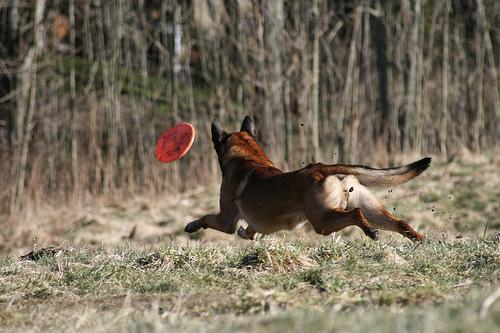

Score: 0.353 | Caption ref: A black and white dog is attempting to catch a yellow and purple object in a low cut yard .


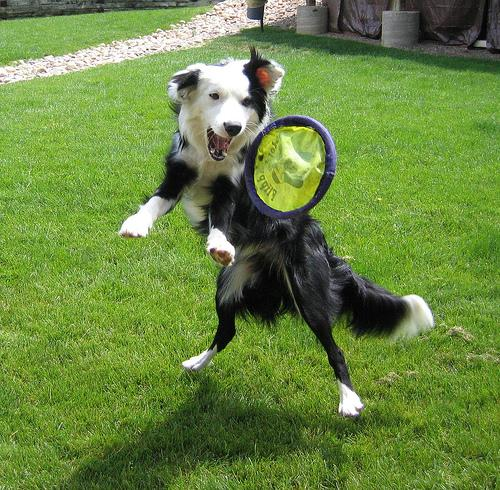

Score: 0.343 | Caption ref: A black and white dog is in the grass with a red striped disk .


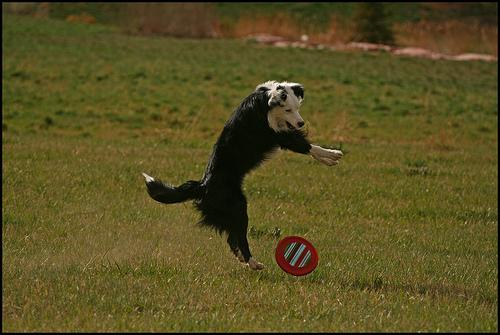

In [ ]:
# Ejemplo 1:
rank_images_by_text("a dog playing with a Frisbee", "test", 3)

Score: 0.296 | Caption ref: "A brown   black   and white dog runs along on the gravel ."


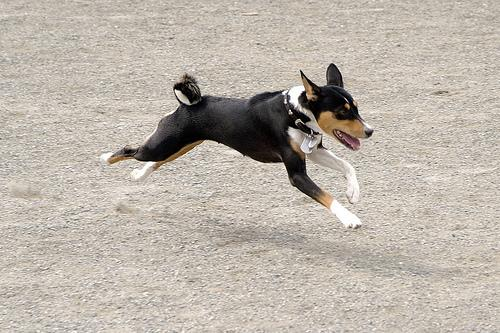

Score: 0.295 | Caption ref: Two brown dogs are running through the green grass .


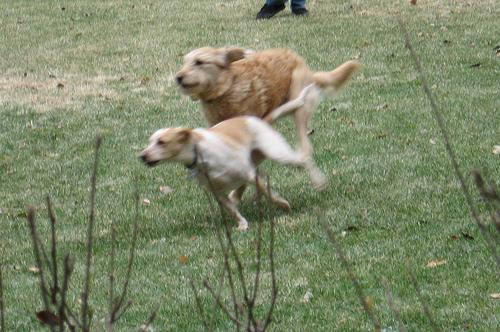

Score: 0.292 | Caption ref: A blond dog jumps in the air on the grass .


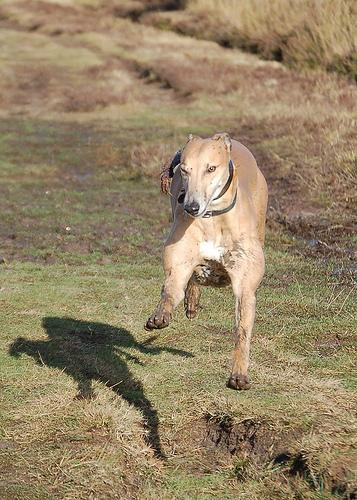

In [ ]:
rank_images_by_text("un perro corriendo", "test", 3)

Prueba de obtener textos de una imagen

In [ ]:
# %%
@torch.no_grad()
def rank_texts_by_image(image_idx: int, dataset_split="test", top_k=5):
    model.eval()
    ex = ds[dataset_split][image_idx]
    img = ex["image"]

    # imagen a embedding
    px = processor(images=[img], return_tensors="pt").to(device)
    with torch.amp.autocast("cuda", enabled=CFG.use_amp):
        img_emb = model.get_image_features(**px)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

    # emb de todos los textos del split
    texts = [x["text"] for x in ds[dataset_split]]
    loader = DataLoader(texts, batch_size=CFG.batch_size, shuffle=False,
                        collate_fn=lambda b: processor(text=b, return_tensors="pt", padding=True, truncation=True),
                        num_workers=2)
    all_txt = []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.amp.autocast("cuda", enabled=CFG.use_amp):
            txt = model.get_text_features(**batch)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        all_txt.append(txt)
    all_txt = torch.cat(all_txt, dim=0)  # (N,D)

    sims = (img_emb @ all_txt.t()).squeeze(0)  # (N,)
    topk = torch.topk(sims, k=top_k).indices.tolist()

    # Mostrar resultado
    display(img)
    print("Top captions:")
    for i, idx in enumerate(topk, 1):
        print(f"{i:02d}. ({sims[idx].item():.3f}) {texts[idx][:160]}")



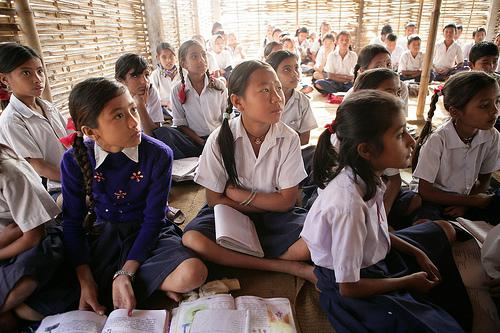

Top captions:
01. (0.285) A class full of students .
02. (0.271) A classroom full of students is looking in the same direction inside a bamboo structure .
03. (0.251) "Adults   and children in school uniforms   move through a flock of pigeons ."
04. (0.228) A teacher is instructing two boys how to use the computer in a class .
05. (0.226) a group of young girls smiling with a large crowd behind them


In [ ]:
# Ejemplo 1:
rank_texts_by_image(0, dataset_split="test", top_k=5)

Guardado y exportar modelo

In [ ]:
# %%
save_dir = os.path.join(CFG.output_dir, "final_clip")
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print("Modelo guardado en:", save_dir)

# (Opcional) subir al Hub:
# from huggingface_hub import login
# login()  # pega tu token
# model.push_to_hub("tu-usuario/clip-flickr8k-finetuned")
# processor.push_to_hub("tu-usuario/clip-flickr8k-finetuned")


Modelo guardado en: ./clip_flickr8k_runs/final_clip
